<table>
<tr>
<td width=15%><img src="./img/UGA.png"></img></td>
<td><center><h1>Introduction to Python for Data Sciences</h1></center></td>
<td width=15%><a href="https://tung-qle.github.io/" style="font-size: 16px; font-weight: bold">Quoc-Tung Le</a> </td>
</tr>
</table>

# A minimal example of training a neural network

In this notebook, we will study how to learn a MLP to perform image classification tasks with Pytorch. We will focus on the MNIST dataset and its corresponding task: predict a numerical digit corresponding to an image.

In [25]:
import torch
import torch.optim as optim
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Overview of the data set

MNIST is an image classification dataset. It contains $60000$ images of hand-written numerial digits from $0 - 9$ (therefore, there are $10$ classes in total).

In [26]:
dataset = MNIST(root = 'data/', download = True)
print(len(dataset))

60000


Image dimension: (28, 28)


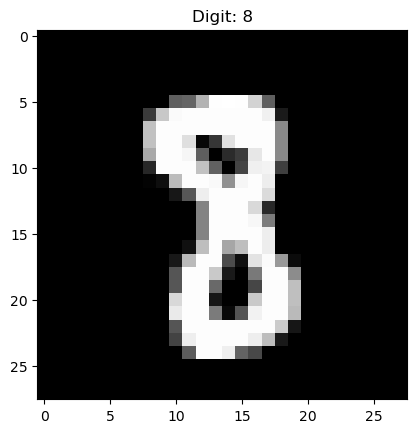

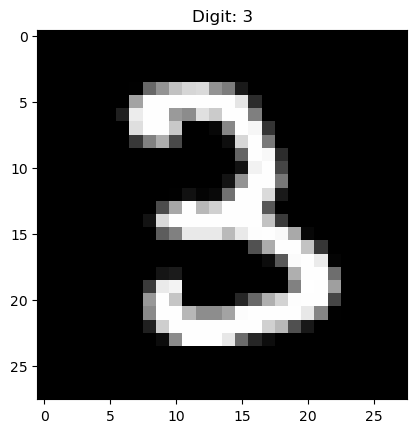

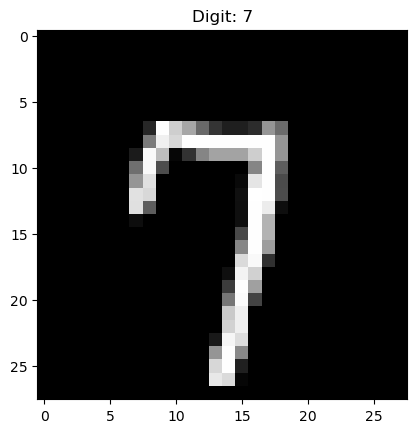

In [27]:
# Show some images with their corresponding digits
print("Image dimension: {}".format(dataset[0][0].size))

for index in np.random.randint(low = 0, high = len(dataset), size = 3):
    image, label = dataset[index]
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.title("Digit: {}".format(label))

There are many small tasks that one needs to complete before getting the models (usually neural networks) trained in Pytorch (and in other deep learning oriented libraries in general). We summerize these tasks below:
1. __Model__: We need to define which architecture that we would like to use. Usually, it means we need to specify the number of layers, their dimensions, 
2. __Optimizers__: We choose and configurate an optimization algorithms. There are many of them available in Pytorch. In this notebook, we will choose the simplest one: _Stochastic Gradient Descent_. Once the algorithm is selected, we need to choose parameters such as learning rate, momentum scalars, etc...
3. __Data preprocessing__: Data needs processing before getting the models trained. For images, we usually have to normalize, apply transformations that do not change the corresponding digits to enrich the training sets.


## 1 - Architecture specification

In this notebook, we will just simply use an MLP architecture that we already saw from the last notebook. In particular, the architecture has $4$ linearl layers of dimensions:

* $784 \times 128$
* $128 \times 64$
* $64 \times 10$
* $10 \times 10$

Between linear layers and ReLU non-linear activation functions. 

In [28]:
class MLP(nn.Module):
    def __init__(self, image_size, num_classes):
        super(MLP, self).__init__()
        self.image_size = image_size
        self.num_classes = num_classes
        
        self.fc0 = nn.Linear(image_size, 128)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10, num_classes)

        self.activation_func = F.relu

    def forward(self, x):
        x = x.view(-1, self.image_size)
        x = self.activation_func(self.fc0(x))
        x = self.activation_func(self.fc1(x))
        x = self.activation_func(self.fc2(x))
        x = self.activation_func(self.fc3(x))
        x = self.fc4(x)
        return x 
    
my_nn = MLP(784, 10)

## 2 - Optimizers preparation

Remember that with a dataset $\mathcal{D} = (x_i,y_i)_{i = 1}^D$ and a neural network with parameters $\theta$, we will learn the _good_ parameter $\theta^\star$ by solving the following problem:

\begin{equation}
    \text{Minimize} \quad \mathcal{L}(\theta) = \sum_{i = 1}^D \ell(f_\theta(x_i), y_i),
\end{equation}

where $\ell(\cdot,\cdot)$ is a certain loss function (such as $\|\cdot - \cdot\|_2^2$).

Pytorch provides many algorithms to solve this problem. We will explore in the following the famous _Stochastic Gradient Descent_ (SGD). Different from the vanilla Gradient Descent, in each iteration, we will only sample a subset of $\mathcal{D}$ of size $K$ and approximate the gradient of $\mathcal{L}$ by:
\begin{equation}
    \nabla \mathcal{L}(\theta) \approx g_K(\theta):= \frac{1}{K} \sum_{i \in \mathcal{K} \subseteq \{1, \ldots, D\}} \nabla \ell(f_\theta(x_i), y_i),
\end{equation}
since this approximation is much cheaper to compute if $K \ll D$. And then the parameter will be updated by:
\begin{equation}
    \theta_{k+1} = \theta_k - \alpha g_K(\theta_k).
\end{equation}

Pytorch helps us to automate this optimization process.

In [29]:
# Define the SGD optimizer with Pytorch
# params: the set of parameters that we want to optimize
# lr: learning rate
# weight_decay: at each iteration, we will additionally reduce the parameters by \theta = (1 - weight_decay) \theta, to avoid the parameters to escape to infinity

optimizer = optim.SGD(params=my_nn.parameters(), lr = 0.01, weight_decay=5e-4)

## 3 - Data prepration
For MNIST, an image dataset, the two following pre-training processes are (almost) obligatory:
1. Data normalization: Rescale all the pixel to [0,1] and then normalize
2. Data augmentation: Since certain transformations such as rotations, shifting or others do not change the labels (the digits), we can exploit this fact by applying these transformations to our training data set. By doing so, we increase enormously the training set. Note that in testing time, we do not apply these transformations.

In [30]:
# batch_size is the number K in our SGD formulation
batch_size = 200

# Define the set of transformations that we want to apply
transform_train = torchvision.transforms.Compose(
        [torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize((0.1307,), (0.3081,))])

transform_test = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize((0.1307,), (0.3081,))])

# Create a loader that allows us to apply transformations, and then take exactly K images at a time
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

## 4 - Actual training

In [31]:
acc_list = []
loss_list = []

# We use CrossEntropy for multi-label classification
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(20):
    total_loss = 0
    total = 0
    for input, output in trainloader:
        optimizer.zero_grad()                               # Reset the gradient to zeros
        train_loss = loss_fn(my_nn(input), output)            # Define the loss functions

        train_loss.backward()                               # Compute the gradients. Note that this is only a stochastic approximation of the true gradient
        
        optimizer.step()                                    # Update the parameters with gradient descent formula

        with torch.no_grad():
            total_loss += train_loss.item() * output.size(0)
            total += output.size(0)

    loss_list.append(total_loss / total)
    print("Epoch {}: \n average loss function is {}.".format(epoch + 1, loss_list[-1]))

    # We check the accuracy on test set every 2 iterations
    if (epoch + 1) % 2 == 0:
        correct = 0
        total = 0
        with torch.no_grad():
            for input, output in testloader:
                _, predictions = torch.max(my_nn(input), 1)
                correct += torch.sum(predictions == output).item()
                total += output.size(0)
            acc_list.append(100 * correct / total)
            print('Accuracy of the network on the {} validation images: {} %'.format(total, 100 * correct / total)) 

Epoch 1: 
 average loss function is 2.310854476292928.
Epoch 2: 
 average loss function is 2.2937814291318257.
Accuracy of the network on the 10000 validation images: 18.06 %
Epoch 3: 
 average loss function is 2.265810777346293.
Epoch 4: 
 average loss function is 2.1700150736172996.
Accuracy of the network on the 10000 validation images: 21.64 %
Epoch 5: 
 average loss function is 1.9970144879817964.
Epoch 6: 
 average loss function is 1.759116903146108.
Accuracy of the network on the 10000 validation images: 48.17 %
Epoch 7: 
 average loss function is 1.3310047566890717.
Epoch 8: 
 average loss function is 0.9887929095824559.
Accuracy of the network on the 10000 validation images: 69.15 %
Epoch 9: 
 average loss function is 0.8632094673315684.
Epoch 10: 
 average loss function is 0.784299895564715.
Accuracy of the network on the 10000 validation images: 75.14 %
Epoch 11: 
 average loss function is 0.7207735129197439.
Epoch 12: 
 average loss function is 0.666733882923921.
Accuracy o

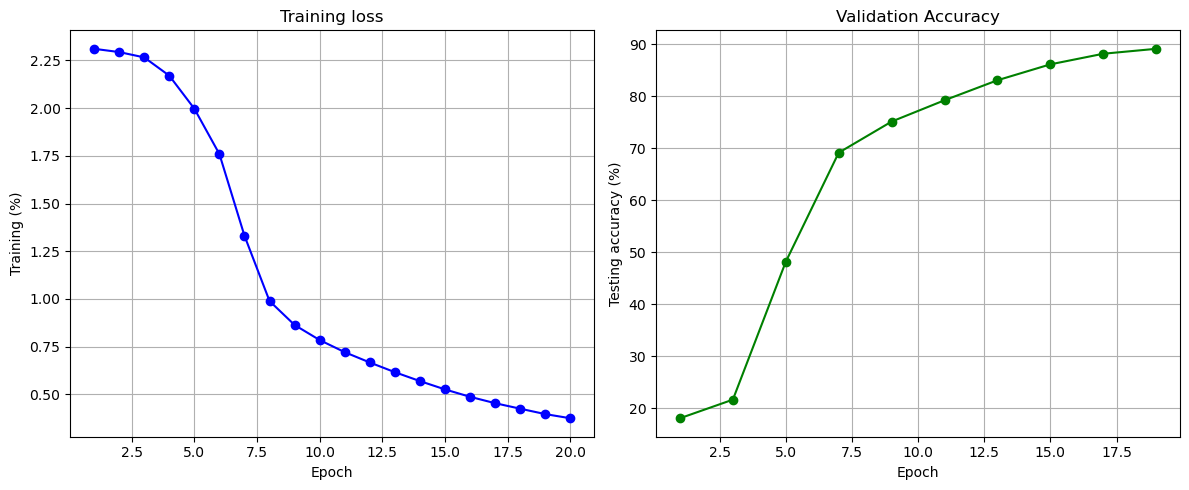

In [33]:
epochs_train = range(1, len(loss_list) + 1)
epochs_acc = range(1, len(loss_list) + 1, 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Training accuracy plot
ax1.plot(epochs_train, loss_list, marker='o', color='blue')
ax1.set_title("Training loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Training (%)")
ax1.grid(True)

# Validation accuracy plot
ax2.plot(epochs_acc, acc_list, marker='o', color='green')
ax2.set_title("Validation Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Testing accuracy (%)")
ax2.grid(True)

plt.tight_layout()
plt.show()

# Exercise


## 1 - Learning rate tuning

Learning rate is usually the most important hyper-parameters. Testing multiple learning rate to see which one works the best (after 20 epochs)

## 2 - Algorithms selection

In fact, $\mathtt{optim.SGD}$ has a parameters $\beta$ that is always $0$ by default. Switch it to $0.9$ to see what happen?

$\mathtt{optim}$ has many other methods such as $\mathtt{AdaGrad}, \mathtt{Adam}$, etc ... Testing those algorithms to see which one gives the best results

## 3 - Architecture selection

For images, there is $\mathtt{torch.nn.Conv2d}$ that is arguably consistent to yield the best results. Try creating an architecture with $\mathtt{torch.nn.Conv2d}$ (and combine with linear and ReLU activation functions, of course) and improve the results